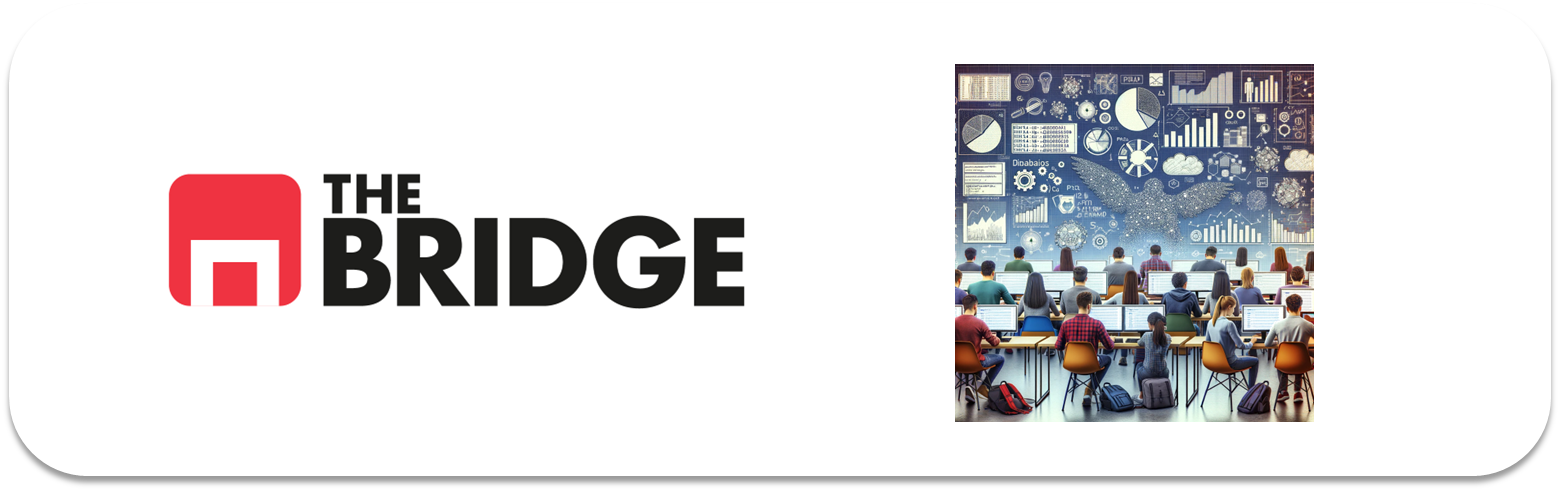

## PRACTICA OBLIGATORIA: **Clasificacion y Regresion Logistica**

* La práctica obligatoria de esta unidad consiste en modelar la supervivencia en el Titanic, por fin, además de una parte adicional multiclase. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import linear_model
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score, balanced_accuracy_score, classification_report,\
                            roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


### Indicaciones

A continuación tienes las indicaciones para hacer el modelado. No necesariamente tienes que seguirlos al pie de la letra, porque a partir de ahora ya las práctica obligatorias dejarán de ser mayormente guiadas por ejercicios y serán más de libre desarrollo, aunque con objetivos específicos, claros y determinados. 

En concreto se pide hacer un modelo de regresión logística, evaluarlo contra un dataset de test reservado del original mostrando las métricas propias de los problemas de clasificación, la matriz de confusión y la curva ROC. Además se pide comparar las predicciones con los valores reales y al final adaptar el modelo a un problema multiclase.

Los pasos para guiar el trabajo:
1. Carga el dataset del Titanic. 
2. Deshazte de las variables que no vayas a usar. Limpia lo que creas necesarios pero no hagas imputaciones.
3. Escoge y analiza la variable target de forma gráfica y razona sobre el impacto de la distribución en los resultados esperados. Ten en cuenta que lo que queremos es poder predecir si un pasajero sobrevivirá.
4. Haz el split en train y test que creas conveniente pero asegurándote que ambos conjuntos tienen un reparto similar de pasajeros embarcados en las tres ciudades.
5. Construye las parejas X,y de train y test.
6. Ahora sí imputa los nulos con medias y modas en la X de train. Guarda esas medias que necesitarás en la parte de test.
7. Haz un mini-EDA, selecciona las features que quieres quedarte y por qué.
8. Trata las variables para que funcionen lo mejor posible en el modelo.
9. Construye un modelo de regresión logística.
10. EXTRA: Analiza si lo crees conveniente los pesos y la importancia de las features.
11. Procesa el dataset de Test para que puedas usarlo en la evaluación 
12. Evalúa tu modelo contra el dataset de test y train. Obten las matrices de confusión y las métricas que creas adecuadas. Haz un pequeño assesment de su generabilidad.
13. EXTRA: Halla la probabilidad de supervivencia de un hombre de entre 30 y 40 años, que embarcó en Southampton en segunda clase, viajaba solo y no pagó el billete. PISTA: En este caso tendrás que calcular varias probabilidades y hacer la media de ellas.
14. EXTRA: Aprovecha todo el trabajo haciendo un único cambio en el target, ahora será la clase del viajero. Cambia el target quitándolo de X_train, X_test y añade a estos el target anterior. El resto no deberías cambiarlo. Entrena y evalua el modelo sólo con el classification_report.  



In [2]:
df_titanic= pd.read_csv("./data/titanic.csv")
df_titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [3]:
primera_eliminacion=["embarked","class","adult_male","deck","alive","alone"]
#Eliminadas porque son redundantes, excepto deck que se elimina pq tiene demsiados nulos 
df_titanic=df_titanic.drop(columns=primera_eliminacion)

In [4]:
# Sibsp hace referencia al numero de esposas y hermanos que acompañan al pasajero, parch hace refernecia al numero de hijos y padres que acompañan al pasajero.
# las junto las 2 en una: numero de acompañantes, y borro las que estan 
df_titanic["n_companions"]= df_titanic["parch"] + df_titanic["sibsp"]
df_titanic= df_titanic.drop(columns=["parch","sibsp"])

In [5]:
print(df_titanic["sex"].value_counts())
print(df_titanic["who"].value_counts())

sex
male      577
female    314
Name: count, dtype: int64
who
man      537
woman    271
child     83
Name: count, dtype: int64


In [6]:
# sex la voy a convertir en una binaria con 1 si es hombre y 0 si es mujer, who la convierto en una binaria con 0 si es niño y 1 si es adulto
df_titanic["male"]= df_titanic["sex"].apply(lambda x: 0 if x=="female" else 1)
df_titanic["adult"]= df_titanic["who"].apply(lambda x: 0 if x=="child" else 1)
df_titanic=df_titanic.drop(columns=["sex","who"])
print(df_titanic["male"].value_counts())
print(df_titanic["adult"].value_counts())

male
1    577
0    314
Name: count, dtype: int64
adult
1    808
0     83
Name: count, dtype: int64


In [7]:
print(df_titanic.info())
df_titanic.head() #Esta bien de momento, despues imputare valores a los nulos y hare un one hot encoding a embark_town

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   survived      891 non-null    int64  
 1   pclass        891 non-null    int64  
 2   age           714 non-null    float64
 3   fare          891 non-null    float64
 4   embark_town   889 non-null    object 
 5   n_companions  891 non-null    int64  
 6   male          891 non-null    int64  
 7   adult         891 non-null    int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 55.8+ KB
None


,survived,pclass,age,fare,embark_town,n_companions,male,adult
0,0,3,22.0,7.2500,Southampton,1,1,1
1,1,1,38.0,71.2833,Cherbourg,1,0,1
2,1,3,26.0,7.9250,Southampton,0,0,1
3,1,1,35.0,53.1000,Southampton,1,0,1
4,0,3,35.0,8.0500,Southampton,0,1,1


<Axes: xlabel='survived', ylabel='count'>

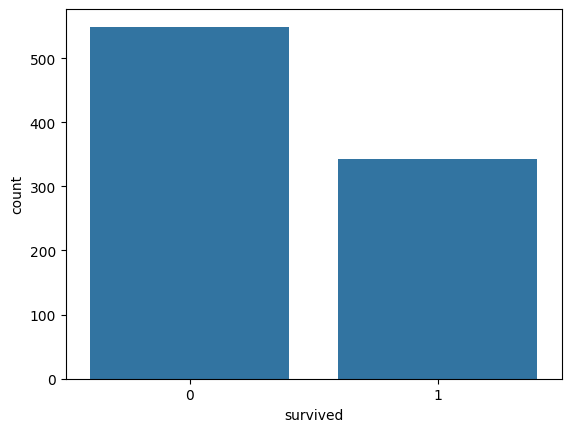

In [8]:
target="survived"
sns.countplot(df_titanic,x=target) 
#Sobrevivieron bastante menos pasajeros de los que murieron pero no son un porcentaje tan minimo como para tener que prestar especial atencion, esta pseudobalanceado.

In [9]:
X= df_titanic.drop(columns=target)
y= df_titanic[target]

X_train,X_test,y_train,y_test= model_selection.train_test_split(X,y,test_size=0.2,random_state=42)
print(df_titanic.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(891, 8)
(712, 7)
(179, 7)
(712,)
(179,)


In [10]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 331 to 102
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   pclass        712 non-null    int64  
 1   age           572 non-null    float64
 2   fare          712 non-null    float64
 3   embark_town   710 non-null    object 
 4   n_companions  712 non-null    int64  
 5   male          712 non-null    int64  
 6   adult         712 non-null    int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 44.5+ KB


In [11]:
#Comienzo la imputacion de nulos calculando la media de edad de adultos y de niños, luego imputo una media de edad u otra segun que categoria sea el pasajero con nulo
media_adult = X_train.loc[X_train['adult'] == 1, 'age'].mean()
media_child = X_train.loc[X_train['adult'] == 0, 'age'].mean()

def imputa_media_edad(row):
    if pd.isna(row['age']):
        return media_adult if row['adult'] == 1 else media_child
    return row['age']

X_train['age'] = X_train.apply(imputa_media_edad, axis=1)

In [12]:
#Ahora imputamos a los dos nulos de embark_town la moda
X_train["embark_town"]=X_train["embark_town"].fillna(X_train["embark_town"].mode()[0])

In [13]:
X_train=pd.get_dummies(X_train,columns=["embark_town"],dtype=int)

In [14]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 331 to 102
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   pclass                   712 non-null    int64  
 1   age                      712 non-null    float64
 2   fare                     712 non-null    float64
 3   n_companions             712 non-null    int64  
 4   male                     712 non-null    int64  
 5   adult                    712 non-null    int64  
 6   embark_town_Cherbourg    712 non-null    int64  
 7   embark_town_Queenstown   712 non-null    int64  
 8   embark_town_Southampton  712 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 55.6 KB


array([[<Axes: title={'center': 'pclass'}>,
        <Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'fare'}>],
       [<Axes: title={'center': 'n_companions'}>,
        <Axes: title={'center': 'male'}>,
        <Axes: title={'center': 'adult'}>],
       [<Axes: title={'center': 'embark_town_Cherbourg'}>,
        <Axes: title={'center': 'embark_town_Queenstown'}>,
        <Axes: title={'center': 'embark_town_Southampton'}>]],
      dtype=object)

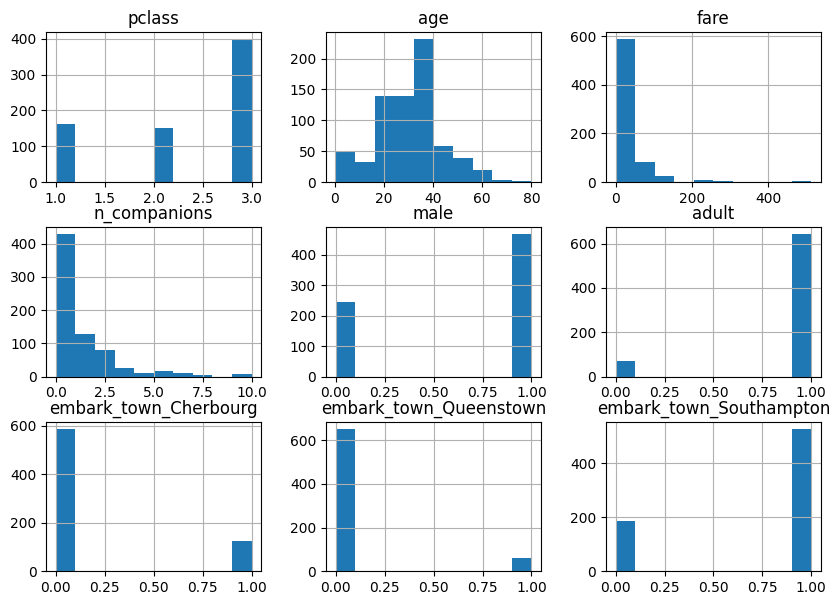

In [15]:
X_train.hist(figsize=(10,7))

In [16]:
features_num= ["age","fare","n_companions"] # age no necesita normalizacion a traves de logaritmo, las otras dos si
features_cat=['pclass', 'male', 'adult','embark_town_Cherbourg', 'embark_town_Queenstown','embark_town_Southampton']
#Se que todas las categoricas son relevantes, hay una diferencia en la distribucion de vivos/muertos dependendiendo de la categoria

In [17]:
train_set= X_train.copy()
train_set["target"]= y_train
corr = train_set.corr()
corr

,pclass,age,fare,n_companions,male,adult,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton,target
pclass,1.000000,-0.301446,-0.546794,0.066748,0.128672,-0.116534,-0.207240,0.203688,0.050762,-0.321750
age,-0.301446,1.000000,0.072746,-0.258441,0.090076,0.605920,0.003696,0.007942,-0.008237,-0.065923
fare,-0.546794,0.072746,1.000000,0.211525,-0.171665,-0.006792,0.250671,-0.108185,-0.148935,0.246641
n_companions,0.066748,-0.258441,0.211525,1.000000,-0.190809,-0.425390,-0.062737,-0.053992,0.088627,0.003565
male,0.128672,0.090076,-0.171665,-0.190809,1.000000,0.102501,-0.069839,-0.046336,0.089938,-0.541750
adult,-0.116534,0.605920,-0.006792,-0.425390,0.102501,1.000000,-0.023538,0.013922,0.011601,-0.127665
embark_town_Cherbourg,-0.207240,0.003696,0.250671,-0.062737,-0.069839,-0.023538,1.000000,-0.139987,-0.778853,0.159632
embark_town_Queenstown,0.203688,0.007942,-0.108185,-0.053992,-0.046336,0.013922,-0.139987,1.000000,-0.512002,-0.006097
embark_town_Southampton,0.050762,-0.008237,-0.148935,0.088627,0.089938,0.011601,-0.778853,-0.512002,1.000000,-0.134623
target,-0.321750,-0.065923,0.246641,0.003565,-0.541750,-0.127665,0.159632,-0.006097,-0.134623,1.000000


<Axes: >

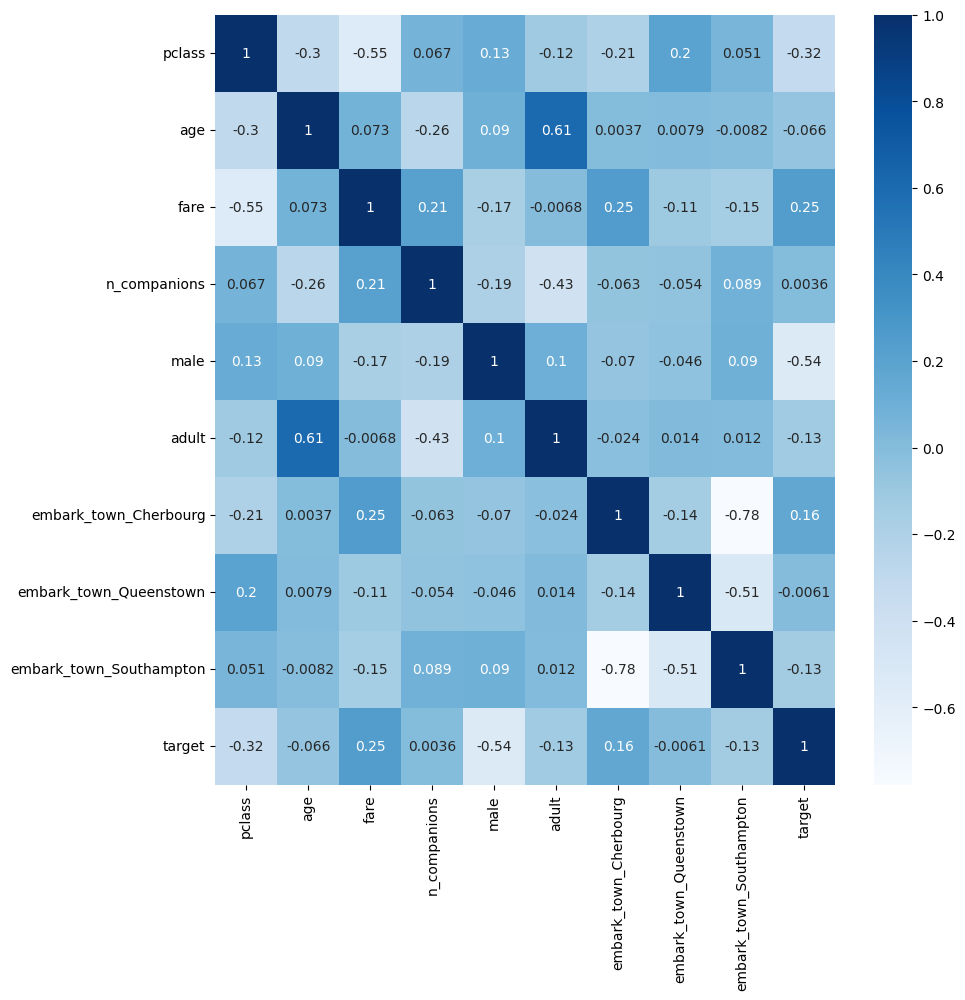

In [18]:
plt.figure(figsize = (10,10))
sns.heatmap(corr, annot = True, cmap = "Blues")

In [19]:
# Me voy a quedar con todas porque no tengo demasiadas aunque n_companions parece prescindible
# Procedo a analizar la colinealidad aunque ya veo en el heatmap que ninguna feature esta super corelacionada con otra, adult y age estan cerca de llegar al 0.7 de corr pero no llegan 
criterio_col = 0.7
excluidas = []
for col in features_num:
    print(f"Voy a comprobar la colinealidad con {col}")
    if col not in excluidas:
        for col_2,valor_corr in corr[col].items():
            print(f"Comprobando con {col_2}")
            if col != col_2 and col_2 in features_num:
                if np.abs(valor_corr) >= criterio_col:
                    print(f"Correlo al {valor_corr}, por eso excluyo a {col_2}")
                    excluidas.append(col_2)
                else:
                    print(f"Conmigo no tiene problema, dejo a {col_2} tranquila")
            elif col == col_2:
                print("soy yo misma, no me excluyo")
            else:
                print("No estaba ya en la lista original, no hago nada")
excluidas = list(set(excluidas))

Voy a comprobar la colinealidad con age
Comprobando con pclass
No estaba ya en la lista original, no hago nada
Comprobando con age
soy yo misma, no me excluyo
Comprobando con fare
Conmigo no tiene problema, dejo a fare tranquila
Comprobando con n_companions
Conmigo no tiene problema, dejo a n_companions tranquila
Comprobando con male
No estaba ya en la lista original, no hago nada
Comprobando con adult
No estaba ya en la lista original, no hago nada
Comprobando con embark_town_Cherbourg
No estaba ya en la lista original, no hago nada
Comprobando con embark_town_Queenstown
No estaba ya en la lista original, no hago nada
Comprobando con embark_town_Southampton
No estaba ya en la lista original, no hago nada
Comprobando con target
No estaba ya en la lista original, no hago nada
Voy a comprobar la colinealidad con fare
Comprobando con pclass
No estaba ya en la lista original, no hago nada
Comprobando con age
Conmigo no tiene problema, dejo a age tranquila
Comprobando con fare
soy yo misma,

In [20]:
#Tengo que usa np.log1p en lugar de np.log pq fare y n_companions tienen valores 0 y me daba error
X_train["fare"] = X_train["fare"].apply(np.log1p)
X_train["n_companions"] = X_train["n_companions"].apply(np.log1p)

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'fare'}>],
       [<Axes: title={'center': 'n_companions'}>, <Axes: >]], dtype=object)

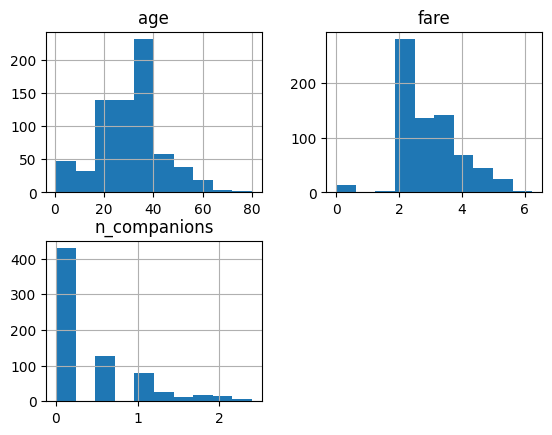

In [21]:
X_train[features_num].hist()

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train[features_num])

StandardScaler()

In [23]:
#Ahora estandarizo 
X_train[features_num] =scaler.transform(X_train[features_num])

In [24]:
#Voy a aplicar todos los cambios al set de test para probar posteriormente el modelo
#Combo de cambios para aplicar al set test
X_test['age'] = X_test.apply(imputa_media_edad, axis=1)
X_test=pd.get_dummies(X_test,columns=["embark_town"],dtype=int)
X_test["fare"] = X_test["fare"].apply(np.log1p)
X_test["n_companions"] = X_test["n_companions"].apply(np.log1p)
X_test[features_num] =scaler.transform(X_test[features_num])
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 179 entries, 709 to 10
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   pclass                   179 non-null    int64  
 1   age                      179 non-null    float64
 2   fare                     179 non-null    float64
 3   n_companions             179 non-null    float64
 4   male                     179 non-null    int64  
 5   adult                    179 non-null    int64  
 6   embark_town_Cherbourg    179 non-null    int64  
 7   embark_town_Queenstown   179 non-null    int64  
 8   embark_town_Southampton  179 non-null    int64  
dtypes: float64(3), int64(6)
memory usage: 14.0 KB


In [25]:
from sklearn.linear_model import LogisticRegression

log_reg= LogisticRegression(max_iter=10000)
log_reg.fit(X_train,y_train)

LogisticRegression(max_iter=10000)

In [26]:
predicciones_train= log_reg.predict(X_train)
predicciones_test= log_reg.predict(X_test)

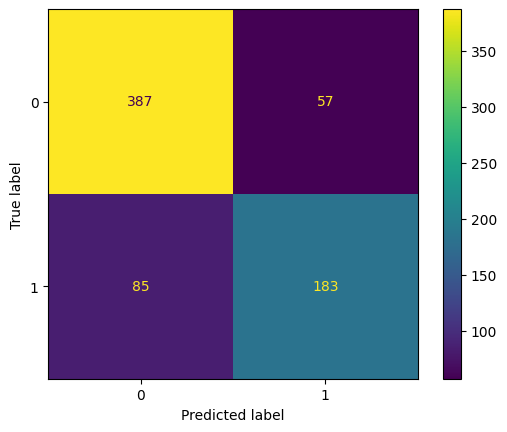

In [27]:
#Evaluaciones con y_train
ConfusionMatrixDisplay.from_predictions(y_train,predicciones_train)

In [28]:
print(classification_report(y_train,predicciones_train)) #Recall bastante bajo en los supervivientes

              precision    recall  f1-score   support

           0       0.82      0.87      0.84       444
           1       0.76      0.68      0.72       268

    accuracy                           0.80       712
   macro avg       0.79      0.78      0.78       712
weighted avg       0.80      0.80      0.80       712



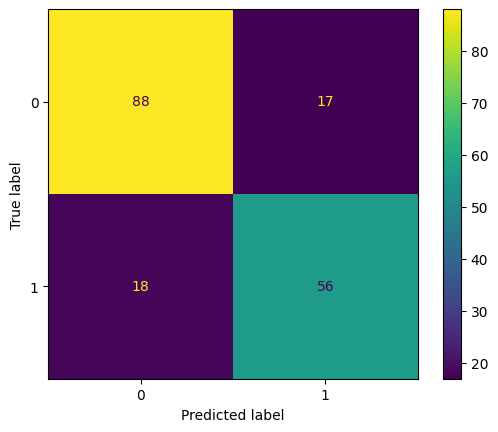

In [29]:
#Evaluaciones con y_test
ConfusionMatrixDisplay.from_predictions(y_test,predicciones_test)

In [30]:
print(classification_report(y_test,predicciones_test)) #Recall algo mejor en la generalizacion

              precision    recall  f1-score   support

           0       0.83      0.84      0.83       105
           1       0.77      0.76      0.76        74

    accuracy                           0.80       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.80      0.80      0.80       179



AUROC: 0.88


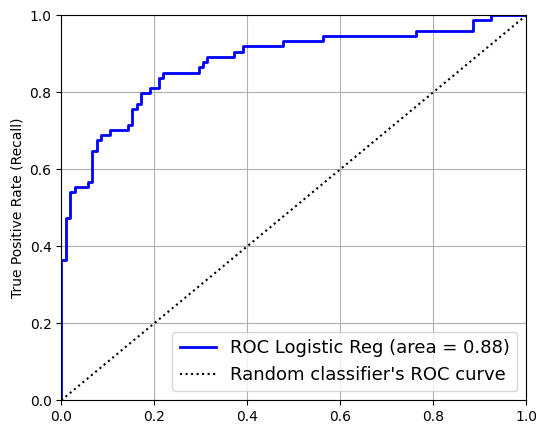

In [31]:
#Metodo pre_hecho para sacar la roc_curve
from sklearn.metrics import roc_curve, auc
scores = log_reg.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, scores[:,1])
roc_auc = auc(fpr,tpr)
print("AUROC: %.2f" %(roc_auc))
plt.figure(figsize=(6, 5))  
plt.plot(fpr, tpr, linewidth=2, color= "blue", label=f"ROC Logistic Reg (area = {roc_auc:0.2f})")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)